In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import os
from sklearn.preprocessing import StandardScaler
import nibabel as nib

from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker

# device = torch.device("cuda:0")
device = torch.device("cpu")

In [2]:
# https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_inverse_covariance_connectome.html#sphx-glr-auto-examples-03-connectivity-plot-inverse-covariance-connectome-py

In [3]:
data_dir = '/users/ntolley/scratch/metanets_data/'

atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

# Loading the functional datasets
data = datasets.fetch_development_fmri(data_dir=data_dir)



In [6]:
masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

n_subjects = 100

df_list = list()
for subj_idx in range(n_subjects):
    time_series = masker.fit_transform(data.func[subj_idx], confounds=data.confounds)
    df_temp = pd.DataFrame(time_series)
    df_temp['subj'] = np.repeat(subj_idx, len(df_temp))

    df_list.append(df_temp)

df = pd.concat(df_list)

[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None


/users/ntolley/.conda/envs/metanets/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:268: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


[Memory]0.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]1.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/users/ntolley/scratch/metanets_data/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7fab79551300>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': '/users/ntolley/n

In [9]:
# df.to_pickle('../data/developmental_df.pkl') 
df = pd.read_pickle('../data/developmental_df.pkl')

In [95]:
class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size, dropout=0.0):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size, [output_size]])
        
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)] )

        self.dropout_list = [nn.Dropout(p=dropout) for _ in range(len(self.layer_list)-1)]
 
    def forward(self, x):
        #Encoding step
        for idx in range(len(self.layer_list) - 1):
            x = torch.tanh(self.layer_list[idx](x))
            x = self.dropout_list[idx](x)
        x = self.layer_list[-1](x)
        return x

class model_ann_autoencoder(nn.Module):
    def __init__(self, input_size, output_size, encoder_layer_size, decoder_layer_size, bottleneck = 10):
        super(model_ann_autoencoder, self).__init__()
        self.input_size, self.output_size = input_size, output_size
        self.encoder_layer_size, self.decoder_layer_size = encoder_layer_size, decoder_layer_size

        self.encoder = model_ann(input_size, bottleneck, layer_size=self.encoder_layer_size)
        self.decoder = model_ann(bottleneck, input_size, layer_size=self.decoder_layer_size)

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)

        return out

In [121]:
class model_lstm(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, dropout, device='cpu', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.input_size = input_size

        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional) 
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden, cell = self.init_hidden(batch_size)

        out, (hidden, cell) = self.lstm(x, (hidden, cell))

        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data.to(self.device)

        #LSTM initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)
        cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device) + 1

        return hidden, cell


class model_lstm_autoencoder(nn.Module):
    def __init__(self, input_size, lstm_encoder_hidden, lstm_decoder_hidden,
                 encoder_layer_size, decoder_layer_size, bottleneck=10, device='cpu'):
        super(model_lstm_autoencoder, self).__init__()
        self.input_size = input_size
        self.encoder_layer_size, self.decoder_layer_size = encoder_layer_size, decoder_layer_size
        self.lstm_encoder_hidden, self.lstm_decoder_hidden = lstm_encoder_hidden, lstm_decoder_hidden
        self.bottleneck = bottleneck

        self.encoder_lstm = model_lstm(input_size=input_size, hidden_dim=lstm_encoder_hidden, n_layers=2, dropout=0.1)
        self.encoder_ann = model_ann(input_size, bottleneck, layer_size=self.encoder_layer_size)
        self.decoder_ann = model_ann(bottleneck, input_size, layer_size=self.decoder_layer_size)
        self.decoder_lstm = model_lstm(input_size=input_size, hidden_dim=lstm_encoder_hidden, n_layers=2, dropout=0.1)

        self.fc = nn.Linear(self.input_size, self.input_size)

    def forward(self, x):
        out = self.encoder_lstm(x)
        out = out.contiguous()
        out = self.encoder_ann(out)

        out = self.decoder_ann(out)
        out = self.decoder_lstm(out)
        out = self.fc(out)
        return out

In [122]:
class SEE_Dataset(torch.utils.data.Dataset):
     def __init__(self, cv_dict, fold, partition, df, window_size=50, data_step_size=1, scaler=None, device=device):
          self.cv_dict = cv_dict
          self.fold = fold
          self.partition = partition
          self.df = df
          self.window_size = window_size
          self.data_step_size = data_step_size

          self.subj_idx = cv_dict[fold][partition]
          self.num_subj = len(self.subj_idx) 
          self.data_list = self.process_dfs(self.df)
          self.X_tensor = self.format_splits(self.data_list)

          # # if scaler is None:
          # scaler = StandardScaler()
          # self.scaler = scaler

          # self.scaler.fit(self.X_tensor)
          # self.X_tensor = self.scaler.transform(self.X_tensor)
          
     def __len__(self):
        #'Denotes the total number of samples'
        return self.num_subj

     # def process_dfs(self, df):
     #      df_filtered = df[np.in1d(df['subj'], self.subj_idx)]
     #      return torch.tensor(df_filtered.values).to(device)

     def process_dfs(self, df):
          data_list = list()
          for subj in self.subj_idx:
               scaler = StandardScaler()
               df_filtered = df[df['subj'] == subj]
               subj_values = df_filtered.values
               subj_values = scaler.fit_transform(subj_values)
               data_list.append(subj_values)
          return data_list

     def format_splits(self, data_list):
          unfolded_data_list = list()
          for trial_idx in range(self.num_subj):
               subj_data = torch.from_numpy(data_list[trial_idx])
            
               unfolded_subj = subj_data.unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
               unfolded_data_list.append(unfolded_subj)
        
          data_tensor = torch.concat(unfolded_data_list, axis=0)
          return data_tensor

          
     def __getitem__(self, slice_index):
          return self.X_tensor[slice_index]

In [123]:
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(n_subjects))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [124]:
batch_size = 256
num_cores = 1

train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}


In [125]:
fold = 1

# Generators
training_set = SEE_Dataset(cv_dict, fold, 'train_idx', df, scaler=None)
scaler = None

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

validation_set = SEE_Dataset(cv_dict, fold, 'validation_idx', df, scaler=scaler)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = SEE_Dataset(cv_dict, fold, 'test_idx', df, scaler=scaler)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

data_arrays = (training_set, validation_set, testing_set)
generators = (training_generator, training_eval_generator, validation_generator, testing_generator)



In [126]:
#Helper function to pytorch train networks for decoding
def train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, print_freq=10, early_stop=20):
    train_loss_array = []
    validation_loss_array = []
    # Loop over epochs
    min_validation_loss, min_validation_std, min_validation_counter, min_validation_epoch = np.inf, np.inf, 0, 0
    for epoch in range(max_epochs):
        #___Train model___
        model.train()
        train_batch_loss = []
        validation_batch_loss = []
        for batch_x in training_generator:
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            batch_x = batch_x.float().to(device)

            output = model(batch_x)
            train_loss = criterion(output, batch_x)
            train_loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly

            train_batch_loss.append(train_loss.item())
        
        train_loss_array.append(train_batch_loss)

        #___Evaluate Model___
        with torch.no_grad():
            model.eval()
            #Generate train set predictions
            for batch_x in validation_generator:
                batch_x = batch_x.float().to(device)

                output = model(batch_x)
                validation_loss = criterion(output, batch_x)

                validation_batch_loss.append(validation_loss.item())

        validation_loss_array.append(validation_batch_loss)

        #Compute average loss on batch
        train_epoch_loss = np.mean(train_batch_loss)
        train_epoch_std = np.std(train_batch_loss)
        validation_epoch_loss = np.mean(validation_batch_loss)
        validation_epoch_std = np.std(validation_batch_loss)

       #Check if validation loss reaches minimum 
        if validation_epoch_loss < min_validation_loss:
            print('*',end='')
            min_validation_loss = np.copy(validation_epoch_loss)
            min_validation_std = np.copy(validation_epoch_std)
            min_validation_counter = 0
            min_validation_epoch = np.copy(epoch+1)

            min_train_loss = np.copy(train_epoch_loss)
            min_train_std = np.copy(train_epoch_std)
            
        else:
            print('.',end='')
            min_validation_counter += 1

        #Print Loss Scores
        if (epoch+1)%print_freq == 0:
            print('')
            print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
            print('Train Loss: {:.4f}  ... Validation Loss: {:.4f}'.format(train_epoch_loss,validation_epoch_loss))
        
        #Early stop if no validation improvement over set number of epochs
        if min_validation_counter > early_stop:
            print(' Early Stop; Min Epoch: {}'.format(min_validation_epoch))
            break

    loss_dict = {'min_validation_loss':min_validation_loss, 'min_validation_std':min_validation_std,'min_validation_epoch':min_validation_epoch, 
    'min_train_loss':min_train_loss, 'min_train_std':min_train_std,
    'train_loss_array':train_loss_array, 'validation_loss_array':validation_loss_array, 'max_epochs':max_epochs}
    return loss_dict

In [127]:
#Define hyperparameters
lr = 1e-2
weight_decay = 0.0
max_epochs = 1000
input_size = training_set[0].shape[1]
criterion = nn.MSELoss()

bottleneck = 10

lstm_encoder_hidden = input_size
lstm_decoder_hidden = input_size
encoder_layer_size = [25]
decoder_layer_size = [25]

# model = model_ann_autoencoder(input_size=input_size, output_size=input_size,
#                               encoder_layer_size=encoder_layer_size, decoder_layer_size=decoder_layer_size,
#                               bottleneck=bottleneck).to(device)

model = model_lstm_autoencoder(input_size, lstm_encoder_hidden, lstm_decoder_hidden,
                               encoder_layer_size, decoder_layer_size, bottleneck=bottleneck)

# Define Loss, Optimizerints h
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#Train model
loss_dict = train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

***.******
Epoch: 10/1000 ... Train Loss: 1.2154  ... Validation Loss: 1.3270
*******.*.
Epoch: 20/1000 ... Train Loss: 0.5443  ... Validation Loss: 0.6127
***.*.**.*
Epoch: 30/1000 ... Train Loss: 0.3733  ... Validation Loss: 0.3596
*.**.*****
Epoch: 40/1000 ... Train Loss: 0.2164  ... Validation Loss: 0.1871
****.*.*.*
Epoch: 50/1000 ... Train Loss: 0.1472  ... Validation Loss: 0.1411
*...*.****
Epoch: 60/1000 ... Train Loss: 0.1264  ... Validation Loss: 0.1317
..**..*..*
Epoch: 70/1000 ... Train Loss: 0.1164  ... Validation Loss: 0.1262
...*......
Epoch: 80/1000 ... Train Loss: 0.1059  ... Validation Loss: 0.1271
 Early Stop; Min Epoch: 74


/tmp/ipykernel_462543/2564509080.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(model(torch.tensor(validation_set[:,-1:,:]).float()).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8)


(100.0, 500.0)

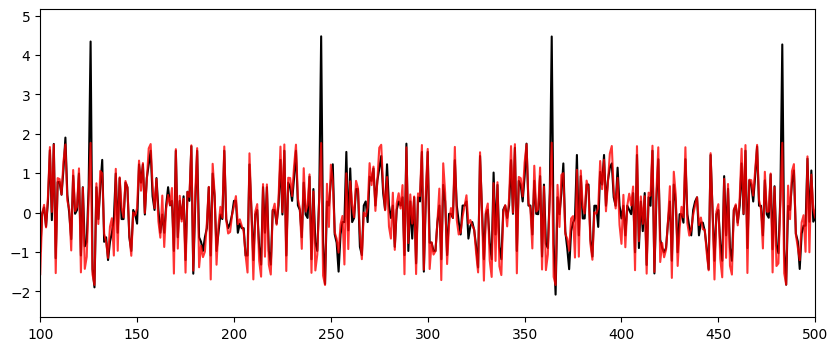

In [132]:
plt.figure(figsize=(10,4))

roi_idx = 10
model.eval()
plt.plot(validation_set[:,-1:,:][:,0,roi_idx], color='k')
plt.plot(model(torch.tensor(validation_set[:,-1:,:]).float()).detach().cpu().numpy()[:, 0, roi_idx], color='r', alpha=0.8)
plt.xlim(100,500)

